In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from os import listdir
from scipy.sparse.linalg import lsmr

from copy import deepcopy


import sys
sys.path.append('../')
sys.path.append('./coves/')
print(sys.path)
import importlib
import myTools
importlib.reload(myTools)
from myTools import create_oh_mut, seq_to_oh, d_aa_to_oh_pos, get_var_explain, get_mse, hamming, alphabet, AA_ALPHABET_STOP
from myTools import AA_ALPHABET,plot_corr_marginal, aa_to_oh, oh_to_aa, hamming, create_oh_mut, get_var_explain, get_mse, fit_log_model, log_layer, get_read_cut_data, fasta_iter_py3, get_subset_data, get_corr_metrics, get_subset_preds, get_all_n_to_var, get_norm_probability

from covesTools import log_layer, log_layer_scale_shift, fit_log_model, read_sampled_mut_key
from covesTools import plot_roc
def sigmoid(x):
    return 1/(1+np.exp(-x))


import tensorflow as tf
print(tf.__version__)
import keras


['/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp', '/home/dd128/mambaforge/envs/dd_tf2_mamba/lib/python310.zip', '/home/dd128/mambaforge/envs/dd_tf2_mamba/lib/python3.10', '/home/dd128/mambaforge/envs/dd_tf2_mamba/lib/python3.10/lib-dynload', '', '/home/dd128/mambaforge/envs/dd_tf2_mamba/lib/python3.10/site-packages', '../', './coves/', '../', './coves/', '../', './coves/', '../', './coves/', '../', './coves/', '../', './coves/']
2.7.0


In [7]:
dout ='./res/out/'

### get the right plt style
plt.style.use('/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/src/paper_style1.mplstyle')

## adding the arial font that had to be downloaded
# following this: https://betterdatascience.com/python-matplotlib-fonts/
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/src/fonts/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

font_manager.findfont('arial') # font_manager.findfont('Arial') doesn't work
from matplotlib import rcParams
rcParams['font.family'] = 'arial'


# correlate antitoxin LOGREG and GVP weights

In [8]:
## get at 10 pos LogReg weights

In [11]:
#########################################################
# define output folder
dout = '/n/groups/marks/users/david/ex62/out/'


# reading in datasets

####################################################################
### 3 position
fin = '/n/groups/marks/users/david/ex62/data/df_mut_all_norm.csv'

df_mut_all = pd.read_csv(fin, index_col = 0)
df_mut_all['muts'] = df_mut_all.index

# getting rid of stop codon ones
df_mut_all_aa = df_mut_all.loc[~((df_mut_all.muts.str[-1] == '_') | (df_mut_all.muts.str[-6] == '_')| (df_mut_all.muts.str[3] == '_'))]

df_mut_all_aa['aa_mut_1'] = df_mut_all_aa.muts.apply(lambda x: x.split(':')[0])
df_mut_all_aa['aa_mut_2'] = df_mut_all_aa.muts.apply(lambda x: x.split(':')[1])
df_mut_all_aa['aa_mut_3'] = df_mut_all_aa.muts.apply(lambda x: x.split(':')[2])


df_mut_all_aa['oh_pos1'] = df_mut_all_aa.apply(lambda r: aa_to_oh(r.aa_mut_1[-1]), axis=1)
df_mut_all_aa['oh_pos2'] = df_mut_all_aa.apply(lambda r: aa_to_oh(r.aa_mut_2[-1]), axis=1)
df_mut_all_aa['oh_pos3'] = df_mut_all_aa.apply(lambda r: aa_to_oh(r.aa_mut_3[-1]), axis=1)
df_mut_all_aa['oh1'] = df_mut_all_aa.apply(lambda r: np.concatenate([r.oh_pos1, r.oh_pos2,r.oh_pos3]),axis=1)


X1 = np.stack(list(df_mut_all_aa['oh1'].values), axis=0)
X1= np.c_[X1,np.ones(X1.shape[0])] # adding a bias term

X_3pos= X1
Y_3pos = df_mut_all_aa['E3'].values.flatten() # 


### 10 position
fin = '/n/groups/marks/users/david/ex62/data/df_704_10x_rc3_col_processed.csv'
df_10pos = pd.read_csv(fin)

# get read_cut
rc = 3
def get_read_cut_df(df, read_cut = 3):
    # returns a dataframe only for variants with at least 3 read pre and post seleciton in both experiments
    df_read = df[(df.pre1>read_cut) &(df.pre2 > read_cut) & (df.post1>read_cut) &(df.post2 > read_cut)]
    return df_read
df_10pos_rc3 = deepcopy(df_10pos)
df_10pos_rc3 = get_read_cut_df(df_10pos_rc3, read_cut=rc)
#normalize
# renormalize fitness for this readcutoff
def norm_lrr(df):
    df['mean_lrr'] = (df['lrr1'] + df['lrr2'])/2

    df_stop = df[df.stop == True]
    df_wt = df[df.wt == True]

    mean_lrr_stop = np.mean(df_stop.mean_lrr)
    mean_lrr_wt = np.mean(df_wt.mean_lrr)

    df['mean_lrr_norm'] = (df.mean_lrr - mean_lrr_stop) / (mean_lrr_wt - mean_lrr_stop)

    df['lrr1_norm'] = (df.lrr1 - np.mean(df_stop['lrr1'])) / (np.mean(df_wt['lrr1']) - np.mean(df_stop['lrr1']))
    df['lrr2_norm'] = (df.lrr2 - np.mean(df_stop['lrr2'])) / (np.mean(df_wt['lrr2']) - np.mean(df_stop['lrr2']))
norm_lrr(df_10pos_rc3)

#filtering truncated mutants out
df_10pos_rc3_no_stop = deepcopy(df_10pos_rc3)
df_10pos_rc3_no_stop = df_10pos_rc3_no_stop.loc[~df_10pos_rc3_no_stop.stop]

# redoing oh pos, because writing and reading np.arrays in df's not good
for i in range(10):
    df_10pos_rc3['oh_pos'+str(i)] = df_10pos_rc3.apply(
        lambda r: aa_to_oh(r['aa_mut_'+str(i)][-1], use_stop=True), 
        axis=1)
    df_10pos_rc3_no_stop['oh_pos'+str(i)] = df_10pos_rc3_no_stop.apply(
        lambda r: aa_to_oh(r['aa_mut_'+str(i)][-1], use_stop=False), 
        axis=1)


oh_cols = [c for c in df_10pos_rc3.columns if c.startswith('oh_pos')]
df_10pos_rc3['oh1'] = df_10pos_rc3.apply(lambda r: np.concatenate([r[c] for c in oh_cols]),axis=1)

oh_cols = [c for c in df_10pos_rc3_no_stop.columns if c.startswith('oh_pos')]
df_10pos_rc3_no_stop['oh1'] = df_10pos_rc3_no_stop.apply(lambda r: np.concatenate([r[c] for c in oh_cols]),axis=1)

# add hamming distance
df_10pos_rc3['hamming'] = df_10pos_rc3.apply(
                                        lambda r: int(np.sum([mut[0]!= mut[-1] for mut in r.muts.split(':')])), 
    axis=1)
df_10pos_rc3_no_stop['hamming'] = df_10pos_rc3_no_stop.apply(
                                        lambda r: int(np.sum([mut[0]!= mut[-1] for mut in r.muts.split(':')])), 
    axis=1)

def get_x_y(df_read):
    X_cut = np.stack(list(df_read['oh1'].values), axis=0)
    X_cut= np.c_[X_cut,np.ones(X_cut.shape[0])] # add bias term
    Y_cut_norm = df_read['mean_lrr_norm'].values
    Y_cut_unnorm = df_read['mean_lrr'].values
    return X_cut, Y_cut_norm, Y_cut_unnorm

X_10pos_rc3,Y_10pos_rc3,Y_unnorm_rc3 = get_x_y(df_10pos_rc3)
X_10pos_rc3_no_stop,Y_10pos_rc3_no_stop,Y_unnorm_rc3_no_stop = get_x_y(df_10pos_rc3_no_stop)


#700: L48, D52, I53, R55,L56
wt_muts_700 = 'L47L:D51D:I52I:R54R:L55L'

# 704: F74, R78, E80, A81, R82
wt_muts_704 = 'F73F:R77R:E79E:A80A:R81R'
wt_muts_10x = wt_muts_700 +':' + wt_muts_704
wt_muts_10x_list = [k[-1] for k in wt_muts_10x.split(':')]
wt_muts_10x_just_mut = ':'.join([k[-1] for k in wt_muts_10x.split(':')])

/tmp/ipykernel_25889/2935796109.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mut_all_aa['aa_mut_1'] = df_mut_all_aa.muts.apply(lambda x: x.split(':')[0])
/tmp/ipykernel_25889/2935796109.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mut_all_aa['aa_mut_2'] = df_mut_all_aa.muts.apply(lambda x: x.split(':')[1])
/tmp/ipykernel_25889/2935796109.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

2023-06-05 13:01:55.691403: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/app/gcc/6.2.0/lib64:/n/app/gcc/6.2.0/lib
2023-06-05 13:01:55.691494: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-05 13:01:55.691545: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (compute-a-16-163.o2.rc.hms.harvard.edu): /proc/driver/nvidia/version does not exist
2023-06-05 13:01:55.694553: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(61, 1)
layer0 weights set to:  [[ 0.08320744]
 [-0.06141881]
 [ 0.48644865]
 [ 0.22274233]
 [-0.06017357]]
beta_hat [ 0.08320745 -0.06141881  0.48644865  0.22274233 -0.06017357]


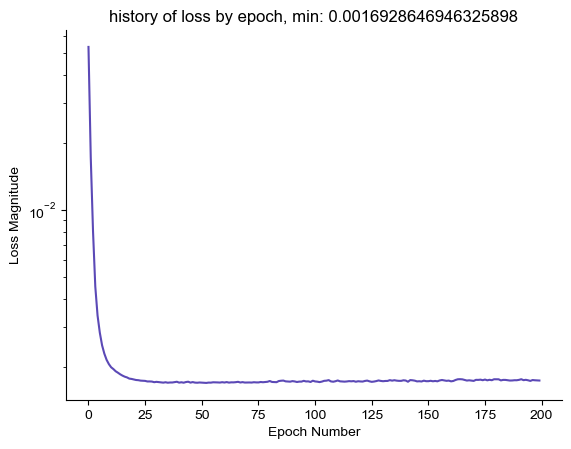

In [13]:
lr=0.1
model_3p, history, callbacks =fit_log_model(X_3pos, Y_3pos, 
                                        my_layer=log_layer(1),
                                        adam_lr =0.1, 
                                         epochs=200,
                                         batch_size=1000)

Yhat_3pos_non= model_3p.predict(X_3pos).flatten()


var explained 0.9761818891571196
mse 0.0016832320700073194
pearsonr 0.9882190353737067
spearmanr 0.9864133601270748


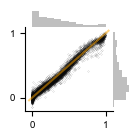

In [14]:
plot_corr_marginal(Yhat_3pos_non, Y_3pos, 
                   figsize=(1.5,1.5),ticksize=7,
                   s=0.01, alpha=0.6,
                   c='grey',
                  fout = dout + 'pos3_nonlin_pred'
                  )

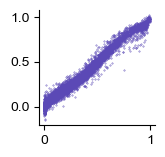

In [21]:
# verify that the ordering is all ok

my_pred = sigmoid(np.dot(X_3pos,model_3p.weights[-1]))
plt.figure(figsize=(1.5,1.5))
plt.scatter(my_pred, Y_3pos, s=0.1)
plt.show()

In [18]:
aa_weights_learned = np.array(model_3p.weights[-1])[:-1] # get rid of bias term
aa_weights_learned.shape

(60, 1)

In [25]:
df_mut_all_aa.iloc[0].muts

'D60A:K63A:E79A'

In [39]:
# get the LR weights

# get the weights learned by LR

# the TA is fit with 20 position OH encoding (aa_to_oh), and uses AA_ALPHABET as the mutants

def get_logreg_w(model, alphabet, dic_p_list_to_mut_p):
    # model is the log_reg model that is fit from tf
    # alphabet is the alphabet used for choosing as a list or str
    # dic_p_list_to_mut_p maps the position in the list of weighs from 1-num_mutated_pos 
    #                       to the actual positions that are mutated
    #                       ie. for the 3 pos AT library: {1:60, 2:63, 3: 79}
    #returns: dictionary of position to 

    len_oh = len(alphabet)
    aa_weights_learned = np.array(model.weights[-1])[:-1] # get rid of bias term
    p_to_mut_to_w_lr = {}
    for p in range(1,len(dic_p_list_to_mut_p)+1):
        pos_w = aa_weights_learned[((p-1)*len_oh):(p)*len_oh].flatten()
        p_to_mut_to_w_lr[dic_p_list_to_mut_p[p]] = dict(zip(alphabet, list(pos_w)))
    return p_to_mut_to_w_lr
    #p_to_mut_to_w_lr

dic_p_list_to_mut_p = {1:61, 2:64, 3: 80}
p_to_mut_to_w_lr_at_3p = get_logreg_w(model_3p,AA_ALPHABET, dic_p_list_to_mut_p)
p_to_mut_to_w_lr_at_3p

{61: {'A': 0.24301666,
  'C': -0.66896504,
  'D': 2.9905362,
  'E': 1.0295264,
  'F': -0.65636647,
  'G': -0.9507745,
  'H': -0.27509156,
  'I': 0.05318751,
  'K': -0.6176243,
  'L': -0.009959939,
  'M': 0.100175895,
  'N': 0.22186935,
  'P': -4.585645,
  'Q': -0.021981323,
  'R': -0.98641986,
  'S': -0.25958386,
  'T': -0.22958285,
  'V': -0.23683451,
  'W': -0.930729,
  'Y': -0.5216043},
 64: {'A': 0.5518081,
  'C': -0.21892896,
  'D': -1.6830543,
  'E': 0.23917978,
  'F': -0.8595606,
  'G': -1.740386,
  'H': -0.04689981,
  'I': 0.8253744,
  'K': 2.9979815,
  'L': -0.2916336,
  'M': 0.18387498,
  'N': -1.0652235,
  'P': -4.5064235,
  'Q': 0.5232056,
  'R': 0.7370141,
  'S': -0.25258735,
  'T': 0.03798089,
  'V': 0.66988873,
  'W': -0.4565118,
  'Y': 0.23279428},
 80: {'A': 0.3532416,
  'C': -0.045923933,
  'D': -0.3005857,
  'E': 1.343688,
  'F': 0.17979698,
  'G': -1.429599,
  'H': 0.110987544,
  'I': 1.072433,
  'K': -0.23468247,
  'L': 0.94042647,
  'M': 0.44911587,
  'N': -0.8149

In [31]:
## get GVP weights
pred_gvp_real = '/n/groups/marks/users/david/ex62/data/res_weights/gvp_100_m_RES_1646945484.3030427_8_220711.csv' # the right file that does have model.eval() and torch.no_grad()
df_gvp_pred = pd.read_csv(pred_gvp_real)

df_gvp_pred['pos'] = df_gvp_pred.mut.str[1:-1].astype(int) # m1_indexed
df_gvp_pred['mut_aa'] = df_gvp_pred.mut.str[-1].astype(str)
df_gvp_pred['p_t1'] = df_gvp_pred.apply(lambda r: get_norm_probability(df_gvp_pred,r.mean_x, r.pos, t=1), axis=1)
df_gvp_pred['log_p_t1'] = np.log(df_gvp_pred['p_t1'])


In [44]:
list(dic_p_list_to_mut_p.values())

[61, 64, 80]

In [50]:
df_gvp_pred_poi =  df_gvp_pred.loc[df_gvp_pred.pos.isin(list(dic_p_list_to_mut_p.values()))]  
df_gvp_pred_poi['lr_w'] = df_gvp_pred_poi.apply(lambda r:p_to_mut_to_w_lr_at_3p[int(r.pos)][r.mut_aa], axis=1)

/tmp/ipykernel_25889/2246091724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gvp_pred_poi['lr_w'] = df_gvp_pred_poi.apply(lambda r:p_to_mut_to_w_lr_at_3p[int(r.pos)][r.mut_aa], axis=1)


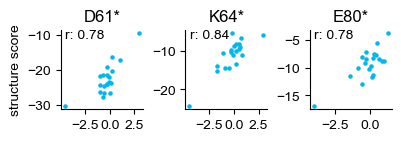

In [119]:
import matplotlib.gridspec as gs
from scipy.stats import pearsonr, spearmanr


dic_p_to_wtaa = {61: 'D61', 64: 'K64', 80: 'E80'}

s=5
c= '#00b7ee'
fig = plt.figure(constrained_layout=True, figsize=(1.3*3, 1.3))
spec = gs.GridSpec(ncols=len(dic_p_list_to_mut_p), nrows = 1, figure=fig)

#
score_col_n_plot = 'mean_x'
#score_col_n_plot = 'log_p_t1'

for i, p in enumerate(dic_p_list_to_mut_p.values()):
    ax= fig.add_subplot(spec[0,i])
    
    if i==0:
        plt.ylabel('structure score')

    
    df_plot = df_gvp_pred_poi.loc[df_gvp_pred_poi.pos == p]
    x= df_plot.lr_w
    y= df_plot[score_col_n_plot]
    ax.scatter(x,y, s=s, c=c)
    ax.set_title(dic_p_to_wtaa[p]+'*')

    # calculate the x and y coordinates to position the text
    
    x_lim, y_lim = ax.get_xlim(), ax.get_ylim()
    x_pos = x_lim[0] + (x_lim[1] - x_lim[0]) * 0.05
    y_pos = y_lim[1] #-(y_lim[1] - y_lim[0]) * 0.05
    x_pos_2 = x_lim[0] + (x_lim[1] - x_lim[0]) * 0.05
    y_pos_2 = y_lim[1] - (y_lim[1] - y_lim[0]) * 0.15

    # use the text() method to add the text to the subplot at the calculated coordinates
    ax.text(x_pos, y_pos, 'r: {:.2f}'.format(pearsonr(x,y)[0]), ha="left", va="top")
plt.savefig(dout + f'3pos_lr_w_vs_{score_col_n_plot}.svg', format='svg')
plt.show()

In [78]:
dout

'/n/groups/marks/users/david/ex62/out/'

## 10 pos weights

(201, 1)
layer0 weights set to:  [[ 0.01701156]
 [-0.01035653]
 [ 0.03116564]
 [ 0.00747865]
 [-0.03876103]]
beta_hat [ 0.01701156 -0.01035653  0.03116564  0.00747865 -0.03876103]


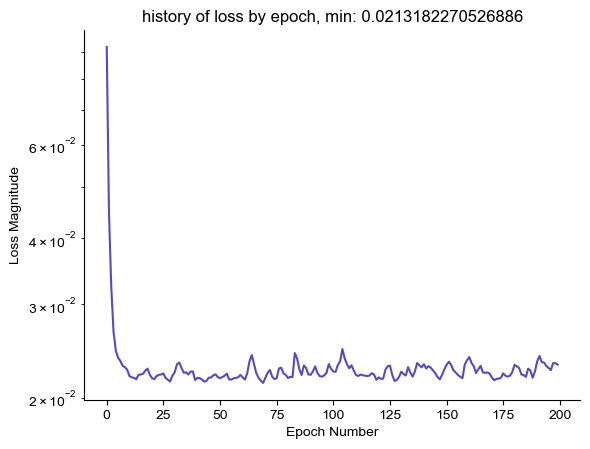

In [79]:
# renormed
model_10p_no_stop, history, callbacks =fit_log_model(
    X_10pos_rc3_no_stop,Y_10pos_rc3_no_stop, 
    my_layer=log_layer(1), # do not scale, just predict between 0 and 1
    adam_lr =0.1, 
    epochs=200,
    batch_size=1000)

Yhat_non_10pos_no_stop= model_10p_no_stop.predict(X_10pos_rc3_no_stop).flatten()


In [102]:
df_gvp_pred.loc[df_gvp_pred.pos==74]

,Unnamed: 0,index,mut,mean_x,std_x,pos,mut_aa,p_t1,log_p_t1
1420,1420,0,F74A,-11.481757,1.170924e-06,74,A,1.942374e-04,-8.546430
1421,1421,1,F74R,-10.116317,1.177933e-06,74,R,7.609145e-04,-7.180990
1422,1422,2,F74N,-10.770209,1.206728e-06,74,N,3.956893e-04,-7.834881
1423,1423,3,F74D,-12.268108,1.528826e-06,74,D,8.847582e-05,-9.332781
1424,1424,4,F74C,-10.424030,1.201630e-06,74,C,5.593680e-04,-7.488703
1425,1425,5,F74E,-9.728718,1.591694e-06,74,E,1.121161e-03,-6.793391
1426,1426,6,F74Q,-9.529199,1.230794e-06,74,Q,1.368730e-03,-6.593872
1427,1427,7,F74G,-13.718845,1.606566e-06,74,G,2.073851e-05,-10.783518
1428,1428,8,F74H,-8.474262,9.974449e-07,74,H,3.930711e-03,-5.538935
1429,1429,9,F74I,-7.236023,1.397149e-06,74,I,1.355912e-02,-4.300696


In [103]:
list_wtaa_pos = ['L48', 'D52', 'I53', 'R55', 'L56', 'F74', 'R78', 'E80', 'A81', 'R82']
dic_pos_to_wtaa_pos = dict(zip([int(m[1:]) for m in list_wtaa_pos], list_wtaa_pos))
dic_p_list_to_mut_p_10p = dict(zip(range(1,len(mut_pos)+1), [int(m[1:]) for m in list_wtaa_pos]))
p_to_mut_to_w_lr_at_10p = get_logreg_w(model_10p_no_stop,AA_ALPHABET, dic_p_list_to_mut_p_10p)
p_to_mut_to_w_lr_at_10p

{48: {'A': -0.22477467,
  'C': 0.11789748,
  'D': -0.12960464,
  'E': 0.1802015,
  'F': -1.179919,
  'G': -0.7206546,
  'H': -0.26781955,
  'I': -0.2015425,
  'K': -0.121281296,
  'L': -0.8384382,
  'M': 0.38796234,
  'N': -0.08118628,
  'P': -1.898427,
  'Q': 0.38117862,
  'R': 0.007666098,
  'S': -0.87027955,
  'T': -0.54063827,
  'V': -0.052104853,
  'W': 0.35798597,
  'Y': -0.9705439},
 52: {'A': -0.9010755,
  'C': -0.9680575,
  'D': 0.09739262,
  'E': 0.50248426,
  'F': -1.2241851,
  'G': -1.6434942,
  'H': -1.7873585,
  'I': -1.349185,
  'K': -1.5123296,
  'L': -1.1341858,
  'M': -2.02555,
  'N': -1.4207143,
  'P': -1.1699971,
  'Q': -1.0901346,
  'R': -1.6684946,
  'S': -1.3840059,
  'T': -1.5745713,
  'V': -1.1070472,
  'W': -1.3067064,
  'Y': -1.4245654},
 53: {'A': -0.029101113,
  'C': -0.9977526,
  'D': 0.15876652,
  'E': -0.37528238,
  'F': -2.190781,
  'G': -1.2644496,
  'H': -2.0317023,
  'I': -0.30335617,
  'K': -1.9824713,
  'L': -0.16224085,
  'M': -0.4681892,
  'N': -

In [105]:
df_gvp_pred_poi_10p =  df_gvp_pred.loc[df_gvp_pred.pos.isin(list(dic_p_list_to_mut_p_10p.values()))]  
df_gvp_pred_poi_10p['lr_w'] = df_gvp_pred_poi_10p.apply(lambda r:p_to_mut_to_w_lr_at_10p[int(r.pos)][r.mut_aa], axis=1)

/tmp/ipykernel_25889/1196446414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gvp_pred_poi_10p['lr_w'] = df_gvp_pred_poi_10p.apply(lambda r:p_to_mut_to_w_lr_at_10p[int(r.pos)][r.mut_aa], axis=1)


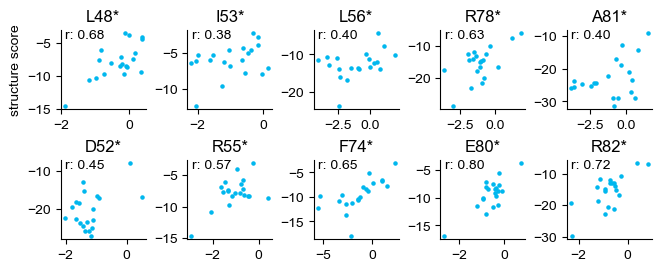

In [120]:

s=5
c= '#00b7ee'

n_rows = 2
n_cols = int(len(p_to_mut_to_w_lr_at_10p)/n_rows)
fig = plt.figure(constrained_layout=True, figsize=(1.3*n_cols, 1.3*n_rows))

spec = gs.GridSpec(ncols=n_cols, nrows = n_rows, figure=fig)

#
score_col_n_plot = 'mean_x'
#score_col_n_plot = 'log_p_t1'

df_data = df_gvp_pred_poi_10p

for i, p in enumerate(dic_p_list_to_mut_p_10p.values()):
    col_num = int(i/n_rows)
    row_num = i%n_rows
    ax= fig.add_subplot(spec[row_num, col_num])
    
    if i==0:
        plt.ylabel('structure score')

    
    df_plot = df_data.loc[df_data.pos == p]
    x= df_plot.lr_w
    y= df_plot[score_col_n_plot]
    ax.scatter(x,y, s=s, c=c)
    ax.set_title(dic_pos_to_wtaa_pos[p]+'*')

    # calculate the x and y coordinates to position the text
    
    x_lim, y_lim = ax.get_xlim(), ax.get_ylim()
    x_pos = x_lim[0] + (x_lim[1] - x_lim[0]) * 0.05
    y_pos = y_lim[1] #-(y_lim[1] - y_lim[0]) * 0.05
    x_pos_2 = x_lim[0] + (x_lim[1] - x_lim[0]) * 0.05
    y_pos_2 = y_lim[1] - (y_lim[1] - y_lim[0]) * 0.15

    # use the text() method to add the text to the subplot at the calculated coordinates
    ax.text(x_pos, y_pos, 'r: {:.2f}'.format(pearsonr(x,y)[0]), ha="left", va="top")
plt.savefig(dout + f'10pos_lr_w_vs_{score_col_n_plot}.svg', format='svg')
plt.show()

# correlate LR weights with RES weights for GFP

 to finish here, copied over

In [67]:
# get the weights learned by LR
aa_weights_learned = np.array(model.weights[-1])[:-1] # get rid of bias term
p_to_mut_to_w_lr = {}
for p in range(1,239):
    pos_w = aa_weights_learned[((p-1)*21):(p)*21].flatten()
    p_to_mut_to_w_lr[p] = dict(zip(alphabet, list(pos_w)))
#p_to_mut_to_w_lr

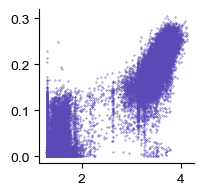

In [86]:
# check for indxing correct by reconstructing output

my_pred = sigmoid(np.dot(X,np.array(model.weights[-1])))
plt.figure(figsize=(2,2))
plt.scatter(Y, my_pred, s=0.1)
plt.show()

In [69]:
# reading in RES structural environment mutation preferences
din = '/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/coves/res/out/'
res_mut_in_gfp = 'gvp_100_m_RES_1646945484.3030427_8_230519_gfp.csv'
#local computer
gfp_sample_dout = '/Users/davidding/Dropbox (HMS)/parESingleLibrary/ex62_gvp/gvp/gvp_samples/gfp_samples/'
#o2 folder
gfp_sample_dout = '/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/coves/gvp_samples/gfp_samples/'
pred_gvp_real = din +res_mut_in_gfp
df_gvp_pred = pd.read_csv(pred_gvp_real)

df_gvp_pred['pos'] = df_gvp_pred.mut.str[1:-1].astype(int)
df_gvp_pred['mut_aa'] = df_gvp_pred.mut.str[-1].astype(str)

In [76]:
p_to_mut_to_w_lr

{1: {'A': 0.08331572,
  'C': 0.035259873,
  'D': 0.09326064,
  'E': 0.04170545,
  'F': -0.05115194,
  'G': 0.013352158,
  'H': 0.02501727,
  'I': 0.0019269834,
  'K': 0.06857954,
  'L': -0.06399894,
  'M': -0.0016760053,
  'N': -0.054476388,
  'P': 0.015933251,
  'Q': -0.025804851,
  'R': -0.035818975,
  'S': 0.04344234,
  'T': -0.030374775,
  'V': 0.06561876,
  'W': -0.02661023,
  'Y': -0.018327175,
  '_': 0.04739381},
 2: {'A': -0.0023461746,
  'C': 0.04754208,
  'D': 0.012717212,
  'E': 0.056925714,
  'F': 0.062267072,
  'G': 0.053909518,
  'H': 0.0059985253,
  'I': -0.03337324,
  'K': -0.044996276,
  'L': -0.04781601,
  'M': -0.02016436,
  'N': 0.051068585,
  'P': 0.064688616,
  'Q': -0.026117114,
  'R': -0.09645168,
  'S': 0.030624904,
  'T': 0.024671707,
  'V': -0.029181799,
  'W': 0.027809141,
  'Y': -0.015239457,
  '_': -0.016582228},
 3: {'A': 0.013731176,
  'C': -0.029750263,
  'D': 0.12011144,
  'E': -0.101722516,
  'F': 0.019365394,
  'G': -0.027346844,
  'H': 0.013293865,


In [88]:
# read experiment file to get mutations that are observed.
df_gfp = pd.read_csv('/n/groups/marks/users/david/ex62/final_data/DMS_data_from_ada/gfp_data_linear_lr.csv', 
                     index_col = 0)
# this might be the wrong set of mutants since mutant and mutseq don't ovelap
muts_seen_dms = set([ind_m for m in df_gfp.mutant for ind_m in m.split(':') ])
#adding the wt residues to each seen position
wt_pos_wt_seen = list(set([m[:-1]+m[0] for m in muts_seen_dms]))
muts_seen_dms = set(list(muts_seen_dms) + wt_pos_wt_seen)
len(muts_seen_dms)
df_gvp_pred['seen_exp'] = df_gvp_pred.mut.apply(lambda x: x in muts_seen_dms)


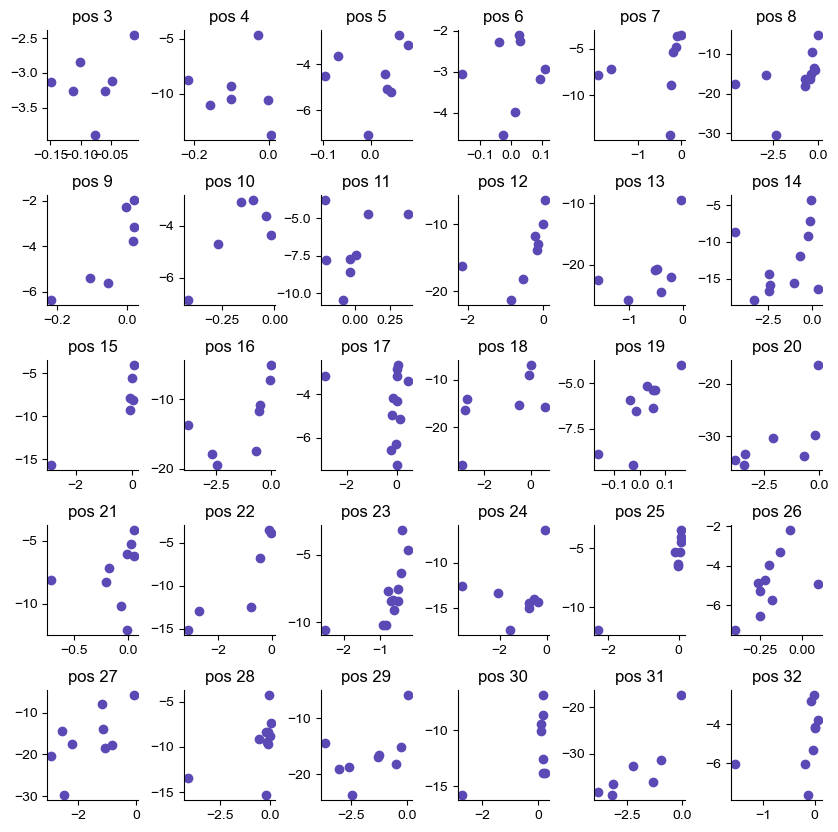

In [96]:
# plotting correlation of mean_x scores and the LR weights

df_gvp_pred['lr_weight'] = df_gvp_pred.apply(lambda r: p_to_mut_to_w_lr[r.pos][r.mut_aa],axis=1)
df_gvp_pred_plot = df_gvp_pred.loc[df_gvp_pred.seen_exp]

num_plots = 30
num_rows = int(num_plots ** 0.5)
num_cols = int((num_plots + num_rows - 1) / num_rows)

# Create a figure and axis objects for all subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10,10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# Flatten the axs array in case the number of subplots is less than the grid size
axs = axs.flatten()

for i, p in enumerate(sorted(list(set(df_gvp_pred.pos))[:num_plots])):
    df_ppos = df_gvp_pred_plot.loc[df_gvp_pred_plot.pos == p]
    ax = axs[i]
    ax.scatter(df_ppos.lr_weight, df_ppos.mean_x) # Customize this line based on your data and desired plot type
    ax.set_title(f"pos {p}")


    plt.show()

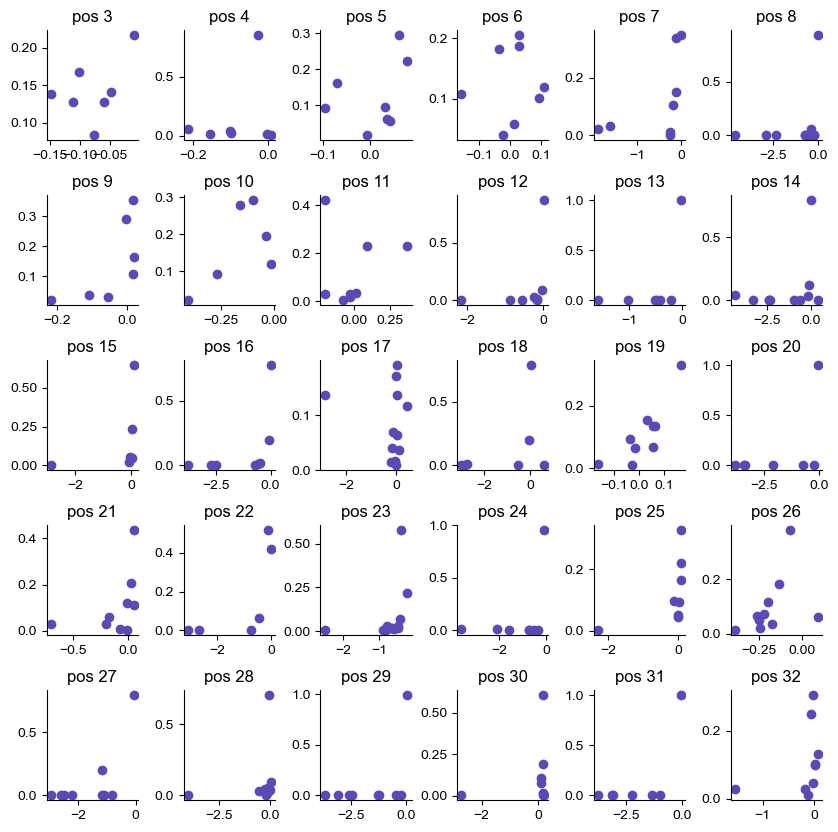

In [114]:
# plotting the actually used sampling probabilities.

# a high temperature like 5, will recapitualte the sampling using the scores themselves.
# a normal sampling temperature like 1-2 will get you more of the max value.

# should you linearly normalize per position the weights to be within a certain range, say -1 and 0?

# goal: find a scheme to:
# so that most things are at the top right. 

def get_norm_prob_log(scores, t=1):
    # getting boltzmann probabilities using scores as energies.
    # assumes that all scores are negative, with the highest number (least negative) being the best.
    # this version gets rid of underflow issues by normalizing the likelihoods by the smalles value
    
    # convert scores to log-probs
    ll = -np.abs(scores)/t
    
    # subtract the largest one so they are not all nan if dealing with small numbers
    ll_norm = np.exp(ll-max(ll))

    p_norm = ll_norm/np.sum(ll_norm)
    return p_norm

df_gvp_pred['lr_weight'] = df_gvp_pred.apply(lambda r: p_to_mut_to_w_lr[r.pos][r.mut_aa],axis=1)
df_gvp_pred_plot = df_gvp_pred.loc[df_gvp_pred.seen_exp]

num_plots = 30
num_rows = int(num_plots ** 0.5)
num_cols = int((num_plots + num_rows - 1) / num_rows)

# Create a figure and axis objects for all subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10,10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# Flatten the axs array in case the number of subplots is less than the grid size
axs = axs.flatten()

for i, p in enumerate(sorted(list(set(df_gvp_pred.pos))[:num_plots])):
    df_ppos = df_gvp_pred_plot.loc[df_gvp_pred_plot.pos == p]
    ax = axs[i]
    ax.scatter(df_ppos.lr_weight, get_norm_prob_log(df_ppos.mean_x, t=1.5)) # Customize this line based on your data and desired plot type
    ax.set_title(f"pos {p}")

plt.show()

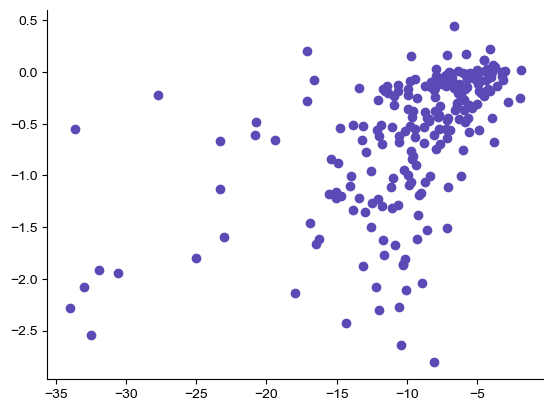

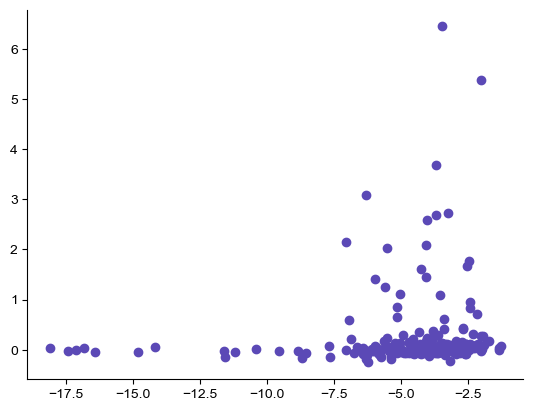

In [111]:
# is there a correlation between the mean of the RES score and the mean of the LR score?
# ie. should you weight by the absolute of the res score

df_min_ppos = df_gvp_pred_plot.groupby('pos').max()
df_mean_ppos = df_gvp_pred_plot.groupby('pos').mean()
plt.figure()
plt.scatter(df_mean_ppos.mean_x, df_mean_ppos.lr_weight)
plt.show()

plt.figure()
plt.scatter(df_max_ppos.mean_x, df_max_ppos.lr_weight)
plt.show()

In [ ]:
df_best_mut_res = df_gvp_pred.loc[df_gvp_pred.groupby('pos')['mean_x'].idxmax()]
sum([m[0] != m[-1] for m in df_gvp_pred.loc[df_gvp_pred.groupby('pos')['mean_x'].idxmax()].mut])

df_gvp_pred_plot